In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("feyzazkefe/trashnet")
print("Path to dataset files:", path)

Path to dataset files: /home/codespace/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1


#### 1. Chargement et organisation des données

In [2]:
import os
from PIL import Image

dataset_dir = dataset_dir = os.path.join(path, "dataset-resized")
classes = os.listdir(dataset_dir)

# Charger les chemins d'images et labels
image_paths = []
labels = []
for cls in classes:
    cls_path = os.path.join(dataset_dir, cls)
    for img_name in os.listdir(cls_path):
        image_paths.append(os.path.join(cls_path, img_name))
        labels.append(cls)

print(f"Nombre total d'images : {len(image_paths)}")
print(f"Classes : {classes}")

Nombre total d'images : 2527
Classes : ['trash', 'metal', 'glass', 'cardboard', 'paper', 'plastic']


#### 2. Séparation train/val/test

In [3]:
from sklearn.model_selection import train_test_split

train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

print(f"Train : {len(train_paths)} | Val : {len(val_paths)} | Test : {len(test_paths)}")

Train : 1616 | Val : 405 | Test : 506


#### 3. Visualisation de la répartition des classes dans chaque split

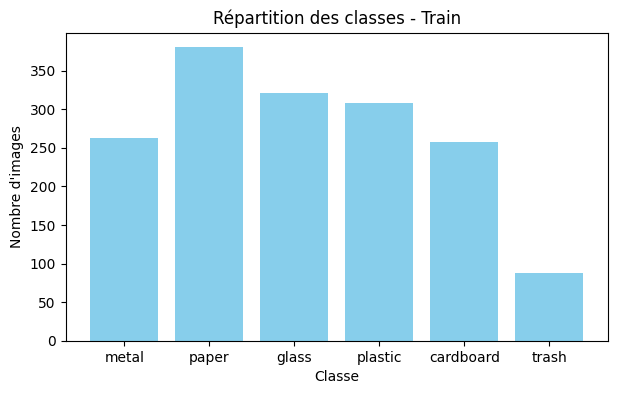

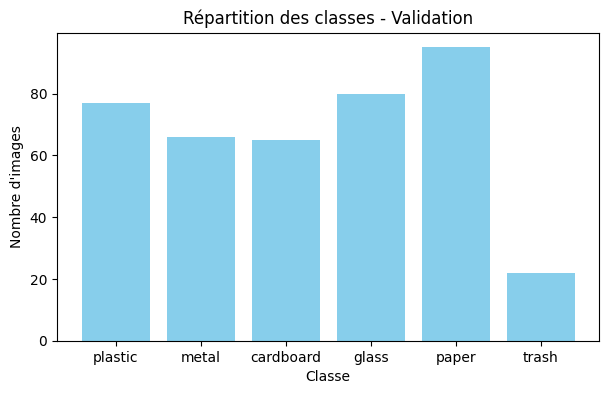

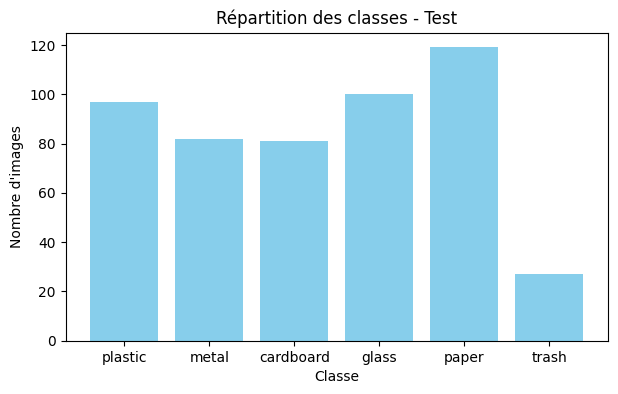

In [4]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_distribution(labels, title):
    counter = Counter(labels)
    plt.figure(figsize=(7,4))
    plt.bar(counter.keys(), counter.values(), color='skyblue')
    plt.title(title)
    plt.xlabel("Classe")
    plt.ylabel("Nombre d'images")
    plt.show()

plot_class_distribution(train_labels, "Répartition des classes - Train")
plot_class_distribution(val_labels, "Répartition des classes - Validation")
plot_class_distribution(test_labels, "Répartition des classes - Test")

# (On ajouteras ensuite les étapes d'augmentation, normalisation, etc.)

### 4. Encodage des labels

In [5]:
# Encodage des labels
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

label_encoder = LabelEncoder()
label_encoder.fit(classes)  # On encode selon l'ordre des classes

# Appliquer l'encodage aux splits
train_labels_enc = label_encoder.transform(train_labels)
val_labels_enc = label_encoder.transform(val_labels)
test_labels_enc = label_encoder.transform(test_labels)

print("Exemple d'encodage :", train_labels[:5], "->", train_labels_enc[:5])
print("Mapping label -> id :", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print(f"\n{"-"*50}\n")

num_classes = len(classes)

train_labels_ohe = tf.keras.utils.to_categorical(train_labels_enc, num_classes=num_classes)
val_labels_ohe = tf.keras.utils.to_categorical(val_labels_enc, num_classes=num_classes)
test_labels_ohe = tf.keras.utils.to_categorical(test_labels_enc, num_classes=num_classes)

print("Exemple d'encodage One-Hot (pour la première image) :")
print(f"Label entier : {train_labels_enc[0]}")
print(f"Label One-Hot : {train_labels_ohe[0]}")
print(f"Shape des labels d'entraînement : {train_labels_ohe.shape}")

2025-08-22 13:49:09.744585: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-22 13:49:09.790571: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-08-22 13:49:11.830556: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


Exemple d'encodage : ['metal', 'paper', 'glass', 'glass', 'metal'] -> [2 3 1 1 2]
Mapping label -> id : {np.str_('cardboard'): np.int64(0), np.str_('glass'): np.int64(1), np.str_('metal'): np.int64(2), np.str_('paper'): np.int64(3), np.str_('plastic'): np.int64(4), np.str_('trash'): np.int64(5)}

--------------------------------------------------

Exemple d'encodage One-Hot (pour la première image) :
Label entier : 2
Label One-Hot : [0. 0. 1. 0. 0. 0.]
Shape des labels d'entraînement : (1616, 6)


### 5. Création de pipeline de données

In [6]:
import tensorflow as tf

IMG_SIZE = 224  # Taille cible des images

def preprocess_image(path, label_ohe):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0
    return img, label_ohe

# Création des datasets avec labels one-hot
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels_ohe))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels_ohe))
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels_ohe))

train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

print("Pipeline de données créé avec succès.")
print("Format de sortie vérifié :", train_ds.element_spec)

Pipeline de données créé avec succès.
Format de sortie vérifié : (TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(6,), dtype=tf.float64, name=None))


2025-08-22 13:49:12.338844: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### 6. Optimisation Finale des Pipelines

In [12]:
BATCH_SIZE = 32  # Taille de lot standard

# Pipeline d'entraînement
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Pipelines de validation et de test
val_ds = val_ds.batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("Pipelines finalisés et optimisés.")
print("Format de sortie du train_ds :", train_ds.element_spec)

Pipelines finalisés et optimisés.
Format de sortie du train_ds : (TensorSpec(shape=(None, None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None))


### 7. Visualisation de quelques images augmentées

2025-08-22 13:50:31.148892: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


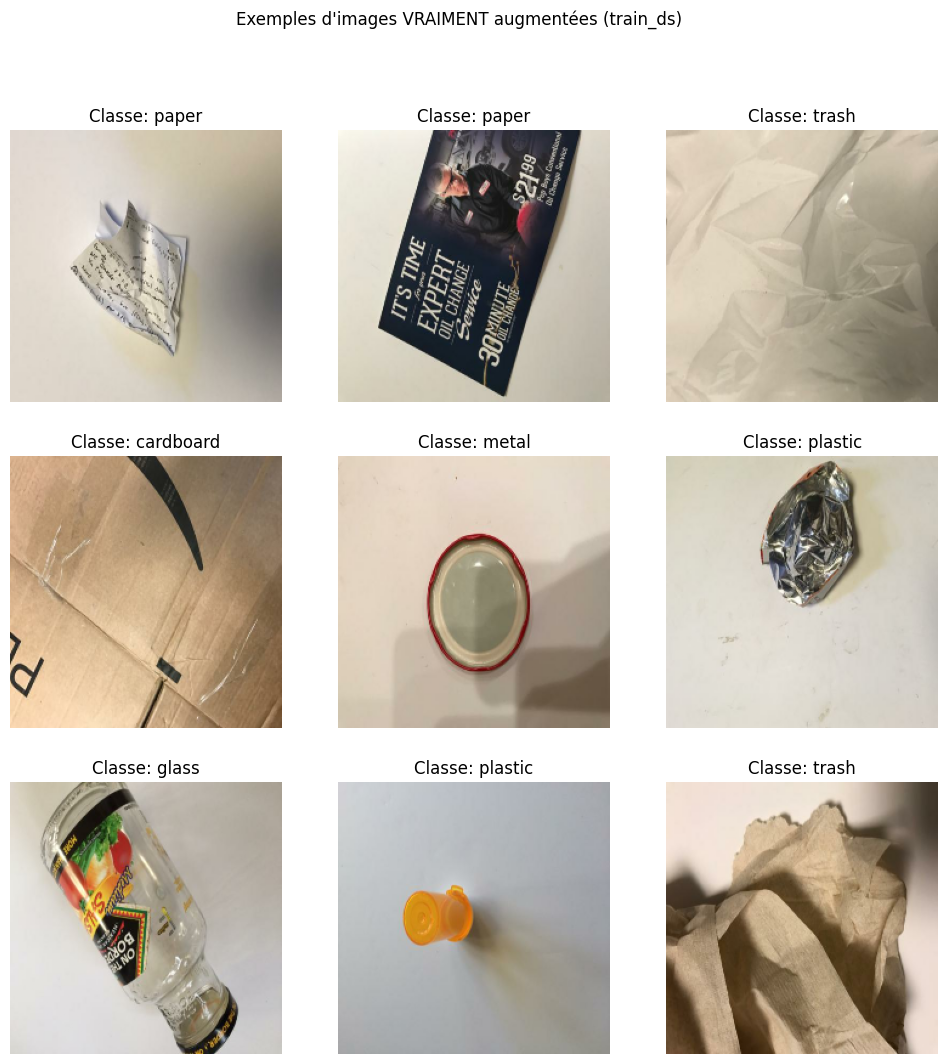

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Prendre un seul lot (batch) du pipeline d'entraînement
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 12))
    
    # On va afficher 9 images pour une belle grille 3x3
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        
        # LA CORRECTION EST ICI : on utilise images[i] pour sélectionner une image différente à chaque fois
        plt.imshow(images[i].numpy())
        
        # On décode et affiche le label pour vérifier que tout est cohérent
        label_index = np.argmax(labels[i].numpy())
        class_name = label_encoder.inverse_transform([label_index])[0]
        plt.title(f"Classe: {class_name}")
        
        plt.axis('off')
        
    plt.suptitle("Exemples d'images VRAIMENT augmentées (train_ds)")
    plt.show()
    break

2025-08-22 13:50:39.706124: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


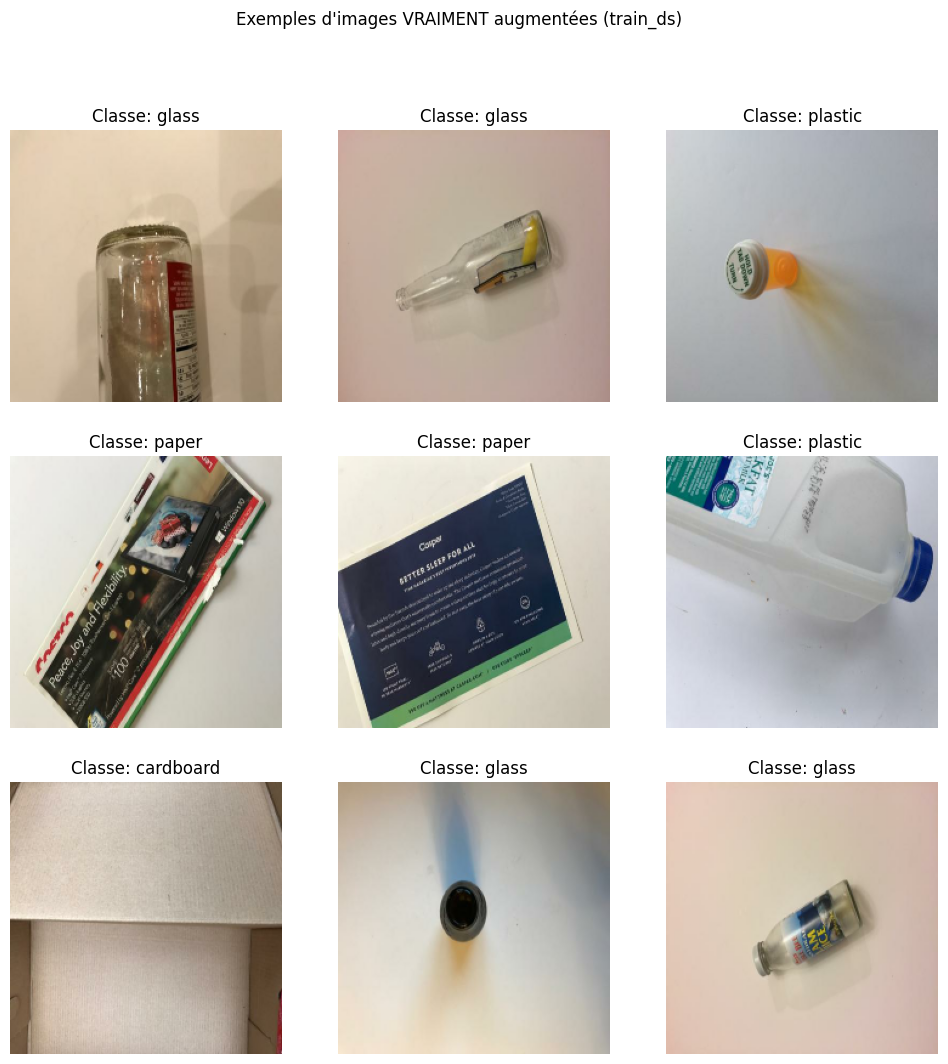

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Visualisation d'un batch d'images augmentées avec leurs labels
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 12))
    for i in range(9):  # Affiche une grille 3x3
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        label_index = np.argmax(labels[i].numpy())
        class_name = label_encoder.inverse_transform([label_index])[0]
        plt.title(f"Classe: {class_name}")
        plt.axis('off')
    plt.suptitle("Exemples d'images VRAIMENT augmentées (train_ds)")
    plt.show()
    break